In [1]:
import os
import numpy as np
import pickle
import shutil 
import pImpactR as impact
import matplotlib.pyplot as plt

# Simulation Setting

In [2]:
npt = 2**13
print(npt)
Espread = 1.0e-3

8192


# Lattice

In [3]:
beam,lattice=impact.readInputFile('IOTA.Chris.in')
beam.nCore_y = 1
beam.nCore_z = 1

reading ImpactZ input file (IOTA.Chris.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
lattice = [ item for item in lattice if not item.type == 'write_raw_ptcl' ]
lattice = [ item for item in lattice if not item.type == '-8' ]
lattice[0].turns = 1
for i in range(len(lattice)):
    if 'length' in lattice[i].keys():
        lattice[i].n_sckick = int(np.ceil(lattice[i].length*80))
elemWrite = impact.getElem('write_raw_ptcl')
elemWrite.file_id   = 999
elemWrite.format_id = 2
lattice.append(elemWrite)

In [5]:
NL_nu = lattice[1].tune_advance
NL_L  = lattice[1].length
NL_c  = 0.01
alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)

In [6]:
arc = lattice.copy()
arc.pop(1)


             length: 1.8 [m]
           n_sckick: 144 [1]
              n_map: 100 [1]
         strength_t: 0.4
 transverse_scale_c: 0.01
        pipe_radius: 10.0 [m]
       tune_advance: 0.3
               type: 'nonlinear_insert'

### lattice TEST: is the arc symmetirc (superperid=2) ? 
- yes for the layout
- no for the magnet strength

In [7]:
for i in range(1,10):
    if arc[i] != arc[-i-1]:
        print(i,arc[i],arc[-i-1])

3 
      length: 0.21 [m]
    n_sckick: 17 [1]
       n_map: 20 [1]
          B1: -7.356207400000001 [T/m]
     file_id: -1
 pipe_radius: 0.15 [m]
  misalign_x: 0.0 [m]
  misalign_y: 0.0 [m]
  rotation_x: 0.0 [rad]
  rotation_y: 0.0 [rad]
  rotation_z: 0.0 [rad]
        type: 'quad' 
      length: 0.21 [m]
    n_sckick: 17 [1]
       n_map: 20 [1]
          B1: -8.24661099047619 [T/m]
     file_id: -1
 pipe_radius: 0.15 [m]
  misalign_x: 0.0 [m]
  misalign_y: 0.0 [m]
  rotation_x: 0.0 [rad]
  rotation_y: 0.0 [rad]
  rotation_z: 0.0 [rad]
        type: 'quad'
5 
      length: 0.21 [m]
    n_sckick: 17 [1]
       n_map: 20 [1]
          B1: 14.219895771428572 [T/m]
     file_id: -1
 pipe_radius: 0.15 [m]
  misalign_x: 0.0 [m]
  misalign_y: 0.0 [m]
  rotation_x: 0.0 [rad]
  rotation_y: 0.0 [rad]
  rotation_z: 0.0 [rad]
        type: 'quad' 
      length: 0.21 [m]
    n_sckick: 17 [1]
       n_map: 20 [1]
          B1: 16.236539680952383 [T/m]
     file_id: -1
 pipe_radius: 0.15 [m]
  misa

# Number of sextupoles

In [8]:
nSext = 0
for item in lattice:
    if item.type == 'multipole_thin':
        print(item.KL_sext)
        nSext = nSext+1
print('nSext=',nSext)

0.15
0.15
0.15
0.15
0.15
0.15
0.15
0.15
0.15
0.15
0.15
0.15
nSext= 12


# Prepare particles

### beam parameter

In [9]:
ke = beam.kinetic_energy
freq = beam.frequency
mass = beam.mass
gam0 = 1.0+beam.kinetic_energy/mass
bet0 = np.sqrt(1.0-1.0/gam0**2)
bg0  = np.sqrt(gam0**2-1.0)
q_m  = beam.multi_charge.q_m[0]

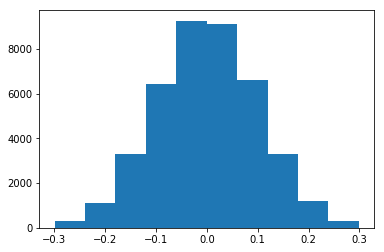

In [10]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10,n=1):
    f = truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    return f.rvs(n)

x=get_truncated_normal(sd=0.1,low=-0.3,upp=0.3,n=npt*5)
plt.hist(x);

In [11]:
pData=np.zeros([npt,9])
pData[:,[0,1,2,3,5]]=x.reshape([npt,5])
pData[:,5] = pData[:,5]/0.1*Espread
pData[:,6] = q_m
pData[:,-1] = np.arange(1,npt+1)

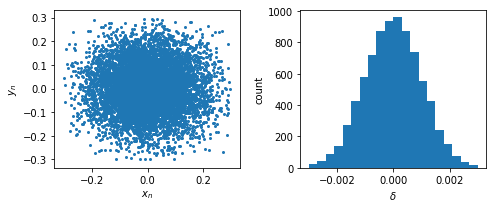

In [12]:
plt.figure(figsize=(7,3))

plt.subplot(1,2,1)
plt.scatter(pData[:,0],pData[:,2],s=4.0);
plt.xlabel('$x_n$')
plt.ylabel('$y_n$')

plt.subplot(1,2,2)
plt.hist(pData[:,5],bins=20);
plt.xlabel('$\delta$')
plt.ylabel('count')

plt.tight_layout()
plt.savefig('initial_pData.png',dpi=120)

In [13]:
def Impact2norm(data_in,bg0,bet0,sign=1):
    data=data_in.copy()
    data[:,5] = -(np.sqrt(1.0-2.0*data[:,5]/(bet0*bg0)+data[:,5]**2/bg0**2)-1.0)/mass
    data[:,1] = (data[:,0]*alfx*sign/np.sqrt(betx) + data[:,1]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx*sign/np.sqrt(betx) + data[:,3]/(1+data[:,5])*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    return data
    
def norm2Impact(data_in,bg0,bet0,sign=1):
    data=data_in.copy()
    data[:,1] = (-data[:,0]*alfx*sign + data[:,1])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,3] = (-data[:,2]*alfx*sign + data[:,3])*NL_c/np.sqrt(betx)*(1+data[:,5])
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c
    data[:,5] = (bg0*np.sqrt(1/bet0**2+2.0*data[:,5]+data[:,5]**2)-bg0/bet0)*mass
    return data

In [14]:
pDataIn = norm2Impact(pData,bg0,bet0,-1)
impact.writeParticleData(pDataIn,ke,mass,freq)
impact.writeInputFile(beam,arc)
impact.run(beam)

0

In [16]:
pDataOut = impact.readParticleData(999, ke, mass, freq, format_id=2)

In [17]:
pData2 = Impact2norm(pDataOut,bg0,bet0,1)